In [1]:
# df_players
# name, elo, state (H/m), move time avg (not possible yet), acpl game avg
# df_games
# p1_ID, p2_ID, winner_ID, date, opening, p1_ELO, p2_ELO
# df_moves
# player_ID, game_ID, time, eval, fen/move, comment

In [129]:
import pandas as pd
import numpy as np

import chess
import chess.pgn
from stockfish import Stockfish
import os
import seaborn as sns

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
#stockfish = Stockfish(
#    'stockfish_14_linux_x64/stockfish_14_linux_x64/stockfish_14_x64', 
#    parameters={"Threads": 2, 'Min Split Depth': 26, 'Ponder':True}
#)
#stockfish.set_elo_rating(2600)
#stockfish.set_skill_level(30)

In [78]:
%%time

players = {
    'White':[],
    'White_Elo': [],
    'Black': [],
    'Black_Elo': [],
    'WhiteIsComp':[],
}

games = {
    'Game_ID': [],
    'Date' : [],
    'White':[],  # Dummy ID
    'White_Elo': [],
    'Black': [],  # Dummy ID
    'Black_Elo': [],
    'ECO': [],
    'Result': [],
}

moves_log_dict = {
    'Game_ID': [],
    'FEN_moves': [],
    'Bitmap_moves': [],
    #'cpl': [],
    'WhiteIsComp': [],
    'turn': [],
    'Castling_right': [],
    'EP_option': [],
    'Pseudo_EP_option': [],
    'Halfmove_clock': []
    #'Result': [],
}

# Set list of Pieces
PIECES = [chess.Piece.from_symbol('P'),
         chess.Piece.from_symbol('N'),
         chess.Piece.from_symbol('B'),
         chess.Piece.from_symbol('R'),
         chess.Piece.from_symbol('Q'),
         chess.Piece.from_symbol('K'),
         chess.Piece.from_symbol('p'),
         chess.Piece.from_symbol('n'),
         chess.Piece.from_symbol('b'),
         chess.Piece.from_symbol('r'),
         chess.Piece.from_symbol('q'),
         chess.Piece.from_symbol('k')]

# read file
pgn = open("/Users/manuel/code/VPeron/cc_detector/raw_data/Fics_data_pc_data.pgn", encoding='UTF-8')  # always a Comp vs Player
game_counter = 0

while True:  # keep reading games
    try:
        game = chess.pgn.read_game(pgn)
        board = game.board()
        moves = list(game.mainline_moves())
        
        if len(moves) > 5:
            # Player
            players['White_Elo'].append(game.headers['WhiteElo'])
            players['Black_Elo'].append(game.headers['BlackElo'])
            players['White'].append(game.headers['White'])
            players['Black'].append(game.headers['Black'])
            players['WhiteIsComp'].append(game.headers.get('WhiteIsComp', 'No'))

            # Games
            games['Game_ID'].append(game.headers['FICSGamesDBGameNo'])
            games['White'].append(game.headers['White'])  # dummy ID
            games['Black'].append(game.headers['Black'])  # dummy ID
            games['White_Elo'].append(game.headers['WhiteElo'])
            games['Black_Elo'].append(game.headers['BlackElo'])
            games['ECO'].append(game.headers['ECO'])
            games['Result'].append(game.headers['Result'])
            games['Date'].append(game.headers['Date'])

            # MOVE CYCLE
            white = True
            for move in moves:
                board.push(move)
                #fen_pos.append(board.fen())
                #stockfish.set_fen_position(board.fen())  # load stockfish with current FEN for eval
                #cpl = stockfish.get_evaluation()['value']/100

                moves_log_dict['Game_ID'].append(game.headers['FICSGamesDBGameNo'])
                moves_log_dict['FEN_moves'].append(board.fen())

                #Generate bitmap representation of FENs
                bitmap_board_dict = {}
                positions = board.piece_map()

                for piece in PIECES:
                    bitmap_board = {}
                    for position in positions:
                        if positions[position] == piece: 
                            bitmap_board[position] = 1
                        else:
                            bitmap_board[position] = 0
                    bitmap_board_dict[str(piece)] = bitmap_board            

                moves_log_dict['Bitmap_moves'].append(bitmap_board_dict)

                #moves_log_dict['cpl'].append(cpl)

                #Turn color and castling availablity
                moves_log_dict['WhiteIsComp'].append(game.headers.get('WhiteIsComp', 'No'))
                if white:
                    moves_log_dict['turn'].append('white')
                    moves_log_dict['Castling_right'].append(int(board.has_castling_rights(chess.WHITE)))
                    white = False
                else:
                    moves_log_dict['turn'].append('black')
                    moves_log_dict['Castling_right'].append(int(board.has_castling_rights(chess.BLACK)))
                    white = True

                #(Pseudo) en passant opportunity
                moves_log_dict['EP_option'].append(int(board.has_legal_en_passant()))
                moves_log_dict['Pseudo_EP_option'].append(int(board.has_pseudo_legal_en_passant()))

                #Halfmove clock
                moves_log_dict['Halfmove_clock'].append(board.halfmove_clock)
            
        game_counter += 1
        if game_counter == 10:  # number of games to read
            break
    except AttributeError:  # no further games to read
        print('No further games to load.')
        break

print(f'{game_counter} games read.')
#TODO takes ~1 sec to process 5 games, too slow.

10 games read.
CPU times: user 549 ms, sys: 255 ms, total: 804 ms
Wall time: 805 ms


In [31]:
("BlackIsComp" or "WhiteIsComp") in game.headers.keys()

True

In [58]:
df_players = pd.DataFrame(players)
#TODO player ID
df_players.head()

,White,White_Elo,Black,Black_Elo,WhiteIsComp
0,forlat,1970,Geforce,2204,Yes
1,Geforce,2201,forlat,1973,No
2,forlat,1976,Geforce,2198,Yes
3,Geforce,2211,forlat,1963,No
4,forlat,1958,Geforce,2216,Yes


In [59]:
df_games = pd.DataFrame(games)
#TODO game ID
#TODO date to datetime
df_games.head()

,Game_ID,Date,White,White_Elo,Black,Black_Elo,ECO,Result
0,490373548,2021.01.31,forlat,1970,Geforce,2204,A01,0-1
1,490373541,2021.01.31,Geforce,2201,forlat,1973,B00,1-0
2,490373526,2021.01.31,forlat,1976,Geforce,2198,A20,0-1
3,490373517,2021.01.31,Geforce,2211,forlat,1963,B10,0-1
4,490373487,2021.01.31,forlat,1958,Geforce,2216,D30,1/2-1/2


In [85]:
moves_log_dict["Bitmap_moves"][1]

{'P': {63: 0,
  62: 0,
  61: 0,
  60: 0,
  59: 0,
  58: 0,
  57: 0,
  56: 0,
  55: 0,
  54: 0,
  53: 0,
  51: 0,
  50: 0,
  49: 0,
  48: 0,
  36: 0,
  17: 1,
  15: 1,
  14: 1,
  13: 1,
  12: 1,
  11: 1,
  10: 1,
  8: 1,
  7: 0,
  6: 0,
  5: 0,
  4: 0,
  3: 0,
  2: 0,
  1: 0,
  0: 0},
 'N': {63: 0,
  62: 0,
  61: 0,
  60: 0,
  59: 0,
  58: 0,
  57: 0,
  56: 0,
  55: 0,
  54: 0,
  53: 0,
  51: 0,
  50: 0,
  49: 0,
  48: 0,
  36: 0,
  17: 0,
  15: 0,
  14: 0,
  13: 0,
  12: 0,
  11: 0,
  10: 0,
  8: 0,
  7: 0,
  6: 1,
  5: 0,
  4: 0,
  3: 0,
  2: 0,
  1: 1,
  0: 0},
 'B': {63: 0,
  62: 0,
  61: 0,
  60: 0,
  59: 0,
  58: 0,
  57: 0,
  56: 0,
  55: 0,
  54: 0,
  53: 0,
  51: 0,
  50: 0,
  49: 0,
  48: 0,
  36: 0,
  17: 0,
  15: 0,
  14: 0,
  13: 0,
  12: 0,
  11: 0,
  10: 0,
  8: 0,
  7: 0,
  6: 0,
  5: 1,
  4: 0,
  3: 0,
  2: 1,
  1: 0,
  0: 0},
 'R': {63: 0,
  62: 0,
  61: 0,
  60: 0,
  59: 0,
  58: 0,
  57: 0,
  56: 0,
  55: 0,
  54: 0,
  53: 0,
  51: 0,
  50: 0,
  49: 0,
  48: 0,
  36:

In [93]:
df_moves = pd.DataFrame(moves_log_dict)
#TODO moves and cpl as features when loading to DB
#TODO game ID from df_games
df_moves.head()

,Game_ID,FEN_moves,Bitmap_moves,WhiteIsComp,turn,Castling_right,EP_option,Pseudo_EP_option,Halfmove_clock
0,490373548,rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR ...,"{'P': {63: 0, 62: 0, 61: 0, 60: 0, 59: 0, 58: ...",Yes,white,1,0,0,0
1,490373548,rnbqkbnr/pppp1ppp/8/4p3/8/1P6/P1PPPPPP/RNBQKBN...,"{'P': {63: 0, 62: 0, 61: 0, 60: 0, 59: 0, 58: ...",Yes,black,1,0,0,0
2,490373548,rnbqkbnr/pppp1ppp/8/4p3/8/1PN5/P1PPPPPP/R1BQKB...,"{'P': {63: 0, 62: 0, 61: 0, 60: 0, 59: 0, 58: ...",Yes,white,1,0,0,1
3,490373548,r1bqkbnr/pppp1ppp/2n5/4p3/8/1PN5/P1PPPPPP/R1BQ...,"{'P': {63: 0, 62: 0, 61: 0, 60: 0, 59: 0, 58: ...",Yes,black,1,0,0,2
4,490373548,r1bqkbnr/pppp1ppp/2n5/4p3/8/1PN1P3/P1PP1PPP/R1...,"{'P': {63: 0, 62: 0, 61: 0, 60: 0, 59: 0, 58: ...",Yes,white,1,0,0,0


In [61]:
#id_list1 = df_moves["Game_ID"].unique()
#id_list2 = df_games["Game_ID"].unique()
#missing = list(set(id_list2) - set(id_list1))
#missing

In [62]:
#df_games[df_games["Game_ID"].isin(missing)]

In [54]:
pgn2 = open("../raw_data/Fics_data_pc_data.pgn", encoding='UTF-8')  # always a Comp vs Player

game_string_list = []
game_counter = 0

while True: 
    
    game = chess.pgn.read_game(pgn2)
    game_string = str(game)
    game_string_list.append(game_string)
    
    game_counter += 1
    if game_counter == 100:  # number of games to read        
        break

print(game_string_list[0])

[Event "FICS rated standard game"]
[Site "FICS freechess.org"]
[Date "2021.01.30"]
[Round "?"]
[White "Abysses"]
[Black "Ibrahimsarabaan"]
[Result "1-0"]
[BlackClock "0:15:00.000"]
[BlackElo "1500"]
[BlackRD "0.0"]
[ECO "A00"]
[FICSGamesDBGameNo "490360601"]
[PlyCount "0"]
[Time "21:50:00"]
[TimeControl "900+0"]
[WhiteClock "0:15:00.000"]
[WhiteElo "2795"]
[WhiteIsComp "Yes"]
[WhiteRD "0.0"]

{ Black resigns } 1-0


# search

In [10]:
def search_df(df, column, value):
    try:
        index = np.where(df[column] == value)
        df = df.iloc[index]
        if len(df) == 0:
            return f'No games found for {value}.'
        return df
    except KeyError as e:
        print(e, f'not found.')

In [11]:
search_df(df_moves, 'ECO', 'A01')

,Game_ID,White,Black,ECO,FEN_moves,WhiteIsComp,Result
0,490373548,forlat,Geforce,A01,[rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR...,Yes,0-1
13,490373289,forlat,Geforce,A01,[rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR...,Yes,0-1
23,490373047,forlat,Geforce,A01,[rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR...,Yes,0-1


In [91]:
move1 = chess.Move.from_uci(uci="g8f6")
move1

Move.from_uci('g8f6')

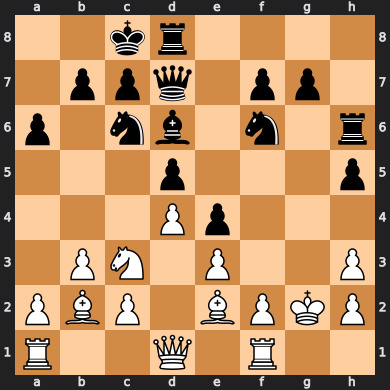

In [94]:
move = df_moves["FEN_moves"][23]
board = chess.Board(move)
board

In [96]:
positions = board.piece_map()

In [97]:
PIECES = list(set((val) for val in positions.values()))
PIECES

[Piece.from_symbol('P'),
 Piece.from_symbol('N'),
 Piece.from_symbol('B'),
 Piece.from_symbol('R'),
 Piece.from_symbol('Q'),
 Piece.from_symbol('K'),
 Piece.from_symbol('p'),
 Piece.from_symbol('n'),
 Piece.from_symbol('b'),
 Piece.from_symbol('r'),
 Piece.from_symbol('q'),
 Piece.from_symbol('k')]

In [98]:
SQUARES = [i for i in range(64)]

In [99]:
bitmap_board_dict = {}

for piece in PIECES:
    bitmap_board = {}
    for square in SQUARES:
        if square in positions.keys():
            if positions[square] == piece: 
                bitmap_board[square] = 1
            else:
                bitmap_board[square] = 0
        else:
            bitmap_board[square] = 0
    bitmap_board_dict[str(piece)] = bitmap_board
    
    df_board = pd.DataFrame(bitmap_board_dict).to_numpy()
    array_wide = df_board.flatten('F')
    bm_list = array_wide.tolist()

In [101]:
len(bm_list)

768

# Data import with package

In [2]:
from cc_detector import data

In [3]:
player_df2, game_df2, move_df2 = data.ChessData().import_data(data_path='../raw_data/Fics_data_pc_data.pgn', 
                                                              import_lim=50)


50 games read.


In [4]:
move_df2

,Game_ID,FEN_moves,Bitmap_moves,WhiteIsComp,turn,Castling_right,EP_option,Pseudo_EP_option,Halfmove_clock
0,490373548,rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR ...,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,white,1,0,0,0
1,490373548,rnbqkbnr/pppp1ppp/8/4p3/8/1P6/P1PPPPPP/RNBQKBN...,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,black,1,0,0,0
2,490373548,rnbqkbnr/pppp1ppp/8/4p3/8/1PN5/P1PPPPPP/R1BQKB...,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,white,1,0,0,1
3,490373548,r1bqkbnr/pppp1ppp/2n5/4p3/8/1PN5/P1PPPPPP/R1BQ...,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,black,1,0,0,2
4,490373548,r1bqkbnr/pppp1ppp/2n5/4p3/8/1PN1P3/P1PP1PPP/R1...,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,white,1,0,0,0
...,...,...,...,...,...,...,...,...,...
2672,490368781,8/5pk1/4p2p/6p1/p2K2PP/3B2P1/1r6/8 b - - 1 41,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,white,0,0,0,1
2673,490368781,8/5pk1/4p2p/6p1/3K2PP/p2B2P1/1r6/8 w - - 0 42,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,black,0,0,0,0
2674,490368781,8/5pk1/4p2p/6p1/6PP/p1KB2P1/1r6/8 b - - 1 42,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,white,0,0,0,1
2675,490368781,8/5pk1/1r2p2p/6p1/6PP/p1KB2P1/8/8 w - - 2 43,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,black,0,0,0,2


## Binary vector representation for board

In [153]:
df_test = pd.DataFrame(move_df2['Bitmap_moves'][0])

In [183]:
df_test 

,P,N,B,R,Q,K,p,n,b,r,q,k
0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
59,0,0,0,0,0,0,0,0,0,0,1,0
60,0,0,0,0,0,0,0,0,0,0,0,1
61,0,0,0,0,0,0,0,0,1,0,0,0
62,0,0,0,0,0,0,0,1,0,0,0,0


In [158]:
np_test = df_test.to_numpy()
np_test

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0,

In [160]:
array_wide = np_test.flatten('F')

In [167]:
dict_wide = {}

for index1, i in enumerate(df_test.columns):
    for index2, j in enumerate(df_test.index):
        dict_wide[str(i)+str(j)] = [df_test.iloc[index2, index1]]

In [164]:
headers = []

for i in df_test.columns:
    for j in df_test.index:
        headers.append(str(i)+str(j))
        
headers

['P0',
 'P1',
 'P2',
 'P3',
 'P4',
 'P5',
 'P6',
 'P7',
 'P8',
 'P9',
 'P10',
 'P11',
 'P12',
 'P13',
 'P14',
 'P15',
 'P16',
 'P17',
 'P18',
 'P19',
 'P20',
 'P21',
 'P22',
 'P23',
 'P24',
 'P25',
 'P26',
 'P27',
 'P28',
 'P29',
 'P30',
 'P31',
 'P32',
 'P33',
 'P34',
 'P35',
 'P36',
 'P37',
 'P38',
 'P39',
 'P40',
 'P41',
 'P42',
 'P43',
 'P44',
 'P45',
 'P46',
 'P47',
 'P48',
 'P49',
 'P50',
 'P51',
 'P52',
 'P53',
 'P54',
 'P55',
 'P56',
 'P57',
 'P58',
 'P59',
 'P60',
 'P61',
 'P62',
 'P63',
 'N0',
 'N1',
 'N2',
 'N3',
 'N4',
 'N5',
 'N6',
 'N7',
 'N8',
 'N9',
 'N10',
 'N11',
 'N12',
 'N13',
 'N14',
 'N15',
 'N16',
 'N17',
 'N18',
 'N19',
 'N20',
 'N21',
 'N22',
 'N23',
 'N24',
 'N25',
 'N26',
 'N27',
 'N28',
 'N29',
 'N30',
 'N31',
 'N32',
 'N33',
 'N34',
 'N35',
 'N36',
 'N37',
 'N38',
 'N39',
 'N40',
 'N41',
 'N42',
 'N43',
 'N44',
 'N45',
 'N46',
 'N47',
 'N48',
 'N49',
 'N50',
 'N51',
 'N52',
 'N53',
 'N54',
 'N55',
 'N56',
 'N57',
 'N58',
 'N59',
 'N60',
 'N61',
 'N62',
 'N6

In [8]:
dict_wide

{'P0': [0],
 'P1': [0],
 'P2': [0],
 'P3': [0],
 'P4': [0],
 'P5': [0],
 'P6': [0],
 'P7': [0],
 'P8': [1],
 'P9': [0],
 'P10': [1],
 'P11': [1],
 'P12': [1],
 'P13': [1],
 'P14': [1],
 'P15': [1],
 'P16': [0],
 'P17': [1],
 'P18': [0],
 'P19': [0],
 'P20': [0],
 'P21': [0],
 'P22': [0],
 'P23': [0],
 'P24': [0],
 'P25': [0],
 'P26': [0],
 'P27': [0],
 'P28': [0],
 'P29': [0],
 'P30': [0],
 'P31': [0],
 'P32': [0],
 'P33': [0],
 'P34': [0],
 'P35': [0],
 'P36': [0],
 'P37': [0],
 'P38': [0],
 'P39': [0],
 'P40': [0],
 'P41': [0],
 'P42': [0],
 'P43': [0],
 'P44': [0],
 'P45': [0],
 'P46': [0],
 'P47': [0],
 'P48': [0],
 'P49': [0],
 'P50': [0],
 'P51': [0],
 'P52': [0],
 'P53': [0],
 'P54': [0],
 'P55': [0],
 'P56': [0],
 'P57': [0],
 'P58': [0],
 'P59': [0],
 'P60': [0],
 'P61': [0],
 'P62': [0],
 'P63': [0],
 'N0': [0],
 'N1': [1],
 'N2': [0],
 'N3': [0],
 'N4': [0],
 'N5': [0],
 'N6': [1],
 'N7': [0],
 'N8': [0],
 'N9': [0],
 'N10': [0],
 'N11': [0],
 'N12': [0],
 'N13': [0],
 'N14'

In [168]:
df_1 = pd.DataFrame(dict_wide)
df_1

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,k54,k55,k56,k57,k58,k59,k60,k61,k62,k63
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [169]:
df_2 = pd.DataFrame(array_wide.reshape(1,-1), columns=headers)
df_2

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,k54,k55,k56,k57,k58,k59,k60,k61,k62,k63
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [180]:
df_check = df_1 == df_2
df_check.iloc[0,:].unique()

array([ True])

In [190]:
boards = []
for line in range(len(move_df2['Bitmap_moves'])):
    df_board = pd.DataFrame(move_df2['Bitmap_moves'][line]).to_numpy()
    array_wide = df_board.flatten('F')
    boards.append(array_wide.reshape(1, -1))

pd.DataFrame(np.concatenate(boards), columns=headers)

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,k54,k55,k56,k57,k58,k59,k60,k61,k62,k63
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2672,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2673,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2674,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2675,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


# Create Input and Target arrays for the model

In [194]:
from cc_detector.move import binary_board_df

In [196]:
%%time

df_wide = binary_board_df(move_df2)

CPU times: user 2.18 s, sys: 14.2 ms, total: 2.19 s
Wall time: 2.19 s


In [64]:
df_wide

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,k54,k55,k56,k57,k58,k59,k60,k61,k62,k63
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2672,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2673,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2674,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2675,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [135]:
game_infos = move_df2[["Game_ID", "turn", "WhiteIsComp", "Castling_right", "EP_option", "Halfmove_clock"]]
game_infos

,Game_ID,turn,WhiteIsComp,Castling_right,EP_option,Halfmove_clock
0,490373548,white,Yes,1,0,0
1,490373548,black,Yes,1,0,0
2,490373548,white,Yes,1,0,1
3,490373548,black,Yes,1,0,2
4,490373548,white,Yes,1,0,0
...,...,...,...,...,...,...
2672,490368781,white,Yes,0,0,1
2673,490368781,black,Yes,0,0,0
2674,490368781,white,Yes,0,0,1
2675,490368781,black,Yes,0,0,2


In [136]:
df_wide_full = df_wide.join(game_infos)
df_wide_full 

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,k60,k61,k62,k63,Game_ID,turn,WhiteIsComp,Castling_right,EP_option,Halfmove_clock
0,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,490373548,white,Yes,1,0,0
1,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,490373548,black,Yes,1,0,0
2,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,490373548,white,Yes,1,0,1
3,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,490373548,black,Yes,1,0,2
4,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,490373548,white,Yes,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2672,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,490368781,white,Yes,0,0,1
2673,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,490368781,black,Yes,0,0,0
2674,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,490368781,white,Yes,0,0,1
2675,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,490368781,black,Yes,0,0,2


## Generate binary Computer variable

In [137]:
df_wide_full["Computer"] = df_wide_full.apply(
    lambda x: 1 if (
        (x["WhiteIsComp"] == "Yes") and (x["turn"] == "white")
    ) or (
        (x["WhiteIsComp"] == "No") and (x["turn"] == "black")
    ) else 0, 
    axis=1)

In [138]:
df_wide_full

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,k61,k62,k63,Game_ID,turn,WhiteIsComp,Castling_right,EP_option,Halfmove_clock,Computer
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,white,Yes,1,0,0,1
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,black,Yes,1,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,white,Yes,1,0,1,1
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,black,Yes,1,0,2,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,white,Yes,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2672,0,0,0,0,0,0,0,0,0,0,...,0,0,0,490368781,white,Yes,0,0,1,1
2673,0,0,0,0,0,0,0,0,0,0,...,0,0,0,490368781,black,Yes,0,0,0,0
2674,0,0,0,0,0,0,0,0,0,0,...,0,0,0,490368781,white,Yes,0,0,1,1
2675,0,0,0,0,0,0,0,0,0,0,...,0,0,0,490368781,black,Yes,0,0,2,0


## Scaling

In [139]:
from sklearn.preprocessing import MinMaxScaler

In [140]:
scaler = MinMaxScaler()

df_wide_full["Halfmove_clock"] = scaler.fit_transform(df_wide_full[["Halfmove_clock"]])

In [141]:
df_wide_full

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,k61,k62,k63,Game_ID,turn,WhiteIsComp,Castling_right,EP_option,Halfmove_clock,Computer
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,white,Yes,1,0,0.000000,1
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,black,Yes,1,0,0.000000,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,white,Yes,1,0,0.021277,1
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,black,Yes,1,0,0.042553,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,white,Yes,1,0,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2672,0,0,0,0,0,0,0,0,0,0,...,0,0,0,490368781,white,Yes,0,0,0.021277,1
2673,0,0,0,0,0,0,0,0,0,0,...,0,0,0,490368781,black,Yes,0,0,0.000000,0
2674,0,0,0,0,0,0,0,0,0,0,...,0,0,0,490368781,white,Yes,0,0,0.021277,1
2675,0,0,0,0,0,0,0,0,0,0,...,0,0,0,490368781,black,Yes,0,0,0.042553,0


## Generate target vector

In [142]:
y = df_wide_full.groupby(by=["Game_ID", "turn"], sort=False).agg(min)["Computer"].values

In [143]:
y.shape

(100,)

In [144]:
y

array([1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0])

## Split df into white and black games

In [145]:
df_white = df_wide_full[df_wide_full["turn"] == "white"]
df_white

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,k61,k62,k63,Game_ID,turn,WhiteIsComp,Castling_right,EP_option,Halfmove_clock,Computer
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,white,Yes,1,0,0.000000,1
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,white,Yes,1,0,0.021277,1
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,white,Yes,1,0,0.000000,1
6,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,white,Yes,1,0,0.042553,1
8,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,white,Yes,1,0,0.021277,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2668,0,0,0,0,0,0,0,0,0,1,...,0,0,0,490368781,white,Yes,0,0,0.000000,1
2670,0,0,0,0,0,0,0,0,0,0,...,0,0,0,490368781,white,Yes,0,0,0.000000,1
2672,0,0,0,0,0,0,0,0,0,0,...,0,0,0,490368781,white,Yes,0,0,0.021277,1
2674,0,0,0,0,0,0,0,0,0,0,...,0,0,0,490368781,white,Yes,0,0,0.021277,1


In [146]:
df_black = df_wide_full[df_wide_full["turn"] == "black"]
df_black

,P0,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,k61,k62,k63,Game_ID,turn,WhiteIsComp,Castling_right,EP_option,Halfmove_clock,Computer
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,black,Yes,1,0,0.000000,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,black,Yes,1,0,0.042553,0
5,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,black,Yes,1,0,0.021277,0
7,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,black,Yes,1,0,0.000000,0
9,0,0,0,0,0,0,0,0,1,0,...,0,0,0,490373548,black,Yes,1,0,0.042553,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,0,0,0,0,0,0,0,0,0,1,...,0,0,0,490368781,black,Yes,0,0,0.106383,0
2669,0,0,0,0,0,0,0,0,0,0,...,0,0,0,490368781,black,Yes,0,0,0.000000,0
2671,0,0,0,0,0,0,0,0,0,0,...,0,0,0,490368781,black,Yes,0,0,0.000000,0
2673,0,0,0,0,0,0,0,0,0,0,...,0,0,0,490368781,black,Yes,0,0,0.000000,0


In [147]:
game_list = df_wide_full["Game_ID"].unique()
game_list 

array(['490373548', '490373541', '490373526', '490373517', '490373487',
       '490373455', '490373444', '490373432', '490373410', '490373400',
       '490373341', '490373333', '490373330', '490373289', '490373220',
       '490373183', '490373172', '490373171', '490373123', '490373120',
       '490373106', '490373079', '490373064', '490373047', '490373033',
       '490372988', '490372924', '490372923', '490372907', '490372902',
       '490372878', '490372808', '490372792', '490372791', '490372784',
       '490372761', '490372704', '490372436', '490372369', '490371006',
       '490370701', '490370653', '490370567', '490370517', '490370512',
       '490369511', '490368927', '490368796', '490368782', '490368781'],
      dtype=object)

## Creating numpy sequences

In [148]:
#create game list of arrays
games_list = []

for game_id in game_list:
    df_w_temp = df_white[df_white["Game_ID"] == game_id].drop(columns=["turn", "WhiteIsComp", "Game_ID", "Computer"])
    games_list.append(np.array(df_w_temp))
    df_b_temp = df_black[df_black["Game_ID"] == game_id].drop(columns=["turn", "WhiteIsComp", "Game_ID", "Computer"])
    games_list.append(np.array(df_b_temp))
    
games_list

[array([[0.        , 0.        , 0.        , ..., 1.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
         0.0212766 ],
        [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.06382979],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.0212766 ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.06382979]]),
 array([[0.        , 0.        , 0.        , ..., 1.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
         0.04255319],
        [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
         0.0212766 ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0. 

## Padding sequences

In [149]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [150]:
X_pad = pad_sequences(games_list, dtype='float32', padding='post', value=-999) # int32 by default
X_pad

array([[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          1.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          1.0000000e+00,  0.0000000e+00,  2.1276595e-02],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          1.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        ...,
        [-9.9900000e+02, -9.9900000e+02, -9.9900000e+02, ...,
         -9.9900000e+02, -9.9900000e+02, -9.9900000e+02],
        [-9.9900000e+02, -9.9900000e+02, -9.9900000e+02, ...,
         -9.9900000e+02, -9.9900000e+02, -9.9900000e+02],
        [-9.9900000e+02, -9.9900000e+02, -9.9900000e+02, ...,
         -9.9900000e+02, -9.9900000e+02, -9.9900000e+02]],

       [[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          1.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          1.0000000e+00,  0.0000000e+00,  4.2553190e-02],
        [ 0.0000000e+00, 

In [151]:
X_pad.shape

(100, 76, 771)

# Import Data and generate feature and target arrays

In [8]:
from cc_detector.data import ChessData

In [9]:
chessdata = ChessData()

In [202]:
player_df, game_df, move_df = chessdata.data_df_maker(data_path='../raw_data/fics_evals.pgn', 
                                                              import_lim=1000)


1000 games read.
1000 games with a total number of 66410 moves parsed.


In [203]:
move_df

,Game_ID,FEN_moves,Bitmap_moves,WhiteIsComp,turn,Castling_right,EP_option,Pseudo_EP_option,Halfmove_clock,Evaluation
0,490373548,rnbqkbnr/pppppppp/8/8/8/1P6/P1PPPPPP/RNBQKBNR ...,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,white,1,0,0,0,79.0
1,490373548,rnbqkbnr/pppp1ppp/8/4p3/8/1P6/P1PPPPPP/RNBQKBN...,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,black,1,0,0,0,-58.0
2,490373548,rnbqkbnr/pppp1ppp/8/4p3/8/1PN5/P1PPPPPP/R1BQKB...,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,white,1,0,0,1,27.0
3,490373548,r1bqkbnr/pppp1ppp/2n5/4p3/8/1PN5/P1PPPPPP/R1BQ...,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,black,1,0,0,2,-145.0
4,490373548,r1bqkbnr/pppp1ppp/2n5/4p3/8/1PN1P3/P1PP1PPP/R1...,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",Yes,white,1,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...
66405,490322849,7k/5p1p/2p2p2/1p3P1Q/r3p3/3q1B1P/6PK/8 w - - 0 29,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",No,black,0,0,0,0,-900.0
66406,490322849,7k/5Q1p/2p2p2/1p3P2/r3p3/3q1B1P/6PK/8 b - - 0 29,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",No,white,0,0,0,0,222.0
66407,490322849,7k/5Q1p/2pq1p2/1p3P2/r3p3/5B1P/6PK/8 w - - 1 30,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",No,black,0,0,0,1,-923.0
66408,490322849,7k/5Q1p/2pq1p2/1p3P2/r3p3/5BPP/7K/8 b - - 0 30,"{'P': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: ...",No,white,0,0,0,0,-821.0


In [204]:
X, y = chessdata.feature_df_maker(move_df)

In [73]:
game_len = []
for game in X:
    game_len.append(game.shape[0])

<AxesSubplot:ylabel='Count'>

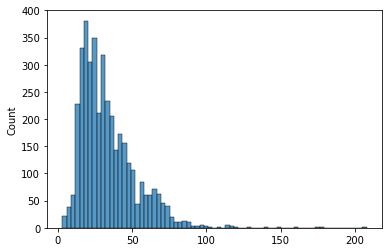

In [76]:
sns.histplot(game_len)

In [98]:
X.shape

(2000, 100, 772)

In [ ]:
np.pad(a, ((3, 2), (2, 3)), 'minimum')

In [84]:
X0_pad = np.pad(X[0],
                ((0,(100-X[0].shape[0])),(0,0)),
                "constant", 
                constant_values=(-999,))

In [85]:
X0_pad.shape

(100, 771)

In [87]:
pd.DataFrame(X0_pad)

,0,1,2,3,4,5,6,7,8,9,...,761,762,763,764,765,766,767,768,769,770
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.006289
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.012579
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.006289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.000000
96,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.000000
97,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.000000
98,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.000000


In [67]:
y.shape

(3954,)

In [ ]:
#  X.shape = (n_SEQUENCES, n_OBSERVATIONS, n_FEATURES)

# LSTM model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Masking
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall, Precision

In [309]:
model = Sequential()

model.add(layers.Masking(mask_value=-999., input_shape=(100, 772)))
model.add(layers.LSTM(units=128, activation='tanh', return_sequences=True, recurrent_dropout=0.2))
model.add(layers.LSTM(units=64, activation='tanh', return_sequences=False, recurrent_dropout=0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=1, activation="sigmoid"))

In [310]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_15 (Masking)        (None, 100, 772)          0         
                                                                 
 lstm_26 (LSTM)              (None, 100, 128)          461312    
                                                                 
 lstm_27 (LSTM)              (None, 64)                49408     
                                                                 
 dense_45 (Dense)            (None, 64)                4160      
                                                                 
 dropout_30 (Dropout)        (None, 64)                0         
                                                                 
 dense_46 (Dense)            (None, 32)                2080      
                                                                 
 dropout_31 (Dropout)        (None, 32)              

In [311]:
recall = Recall()
precision = Precision()

In [312]:
# The compilation
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=["accuracy"])

In [313]:
model.get_config()

{'name': 'sequential_15',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 100, 772),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'masking_15_input'}},
  {'class_name': 'Masking',
   'config': {'name': 'masking_15',
    'trainable': True,
    'batch_input_shape': (None, 100, 772),
    'dtype': 'float32',
    'mask_value': -999.0}},
  {'class_name': 'LSTM',
   'config': {'name': 'lstm_26',
    'trainable': True,
    'dtype': 'float32',
    'return_sequences': True,
    'return_state': False,
    'go_backwards': False,
    'stateful': False,
    'unroll': False,
    'time_major': False,
    'units': 128,
    'activation': 'tanh',
    'recurrent_activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'recurrent_initializer': {'class_name': 'Orthogonal',
     'config': {'gain': 1.0, 'seed': None}},
    'bias_initializer': {'class_name': 'Ze

In [314]:
es = EarlyStopping(restore_best_weights=True, patience=5)

In [315]:
# The fit
history2 = model.fit(X, y, 
          batch_size=32, 
          epochs=50,
          callbacks=[es],
          validation_split=0.2,
          verbose=1)

Epoch 1/50
50/50 [==============================] - 16s 241ms/step - loss: 0.6985 - accuracy: 0.4706 - val_loss: 0.6927 - val_accuracy: 0.5200
Epoch 2/50
50/50 [==============================] - 11s 212ms/step - loss: 0.6960 - accuracy: 0.4944 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 3/50
50/50 [==============================] - 10s 209ms/step - loss: 0.6958 - accuracy: 0.4988 - val_loss: 0.6930 - val_accuracy: 0.5025
Epoch 4/50
50/50 [==============================] - 10s 208ms/step - loss: 0.6949 - accuracy: 0.5038 - val_loss: 0.6930 - val_accuracy: 0.4900
Epoch 5/50
50/50 [==============================] - 11s 212ms/step - loss: 0.6936 - accuracy: 0.4963 - val_loss: 0.6993 - val_accuracy: 0.5000
Epoch 6/50
50/50 [==============================] - 10s 208ms/step - loss: 0.6895 - accuracy: 0.5375 - val_loss: 0.6562 - val_accuracy: 0.6175
Epoch 7/50
50/50 [==============================] - 11s 216ms/step - loss: 0.6534 - accuracy: 0.5994 - val_loss: 0.5865 - val_accuracy: 0.6575

## Import trainer from python file

In [258]:
from sklearn.model_selection import train_test_split
from cc_detector.trainer import Trainer
from cc_detector.predict import predict_comp, rtp_input

In [336]:
trainer = Trainer()

In [165]:
path_eval = '../raw_data/fics_evals.pgn'
path_no_eval = '../raw_data/Fics_data_pc_data.pgn'

In [166]:
%%time

player_df, game_df, move_df = trainer.get_data(data_path=path_eval,
                                               import_lim=1000)

1000 games read.
1000 games with a total number of 66410 moves parsed.
CPU times: user 33.3 s, sys: 1.82 s, total: 35.1 s
Wall time: 36.8 s


In [246]:
%%time

X, y = trainer.transform_move_data(move_df=move_df,
                                  max_game_length=100,
                                  source="gcp")

Data has been transformed into the correct format. ✅
                  Training mode was chosen (X and y will be returned).
CPU times: user 1min 16s, sys: 11.8 s, total: 1min 28s
Wall time: 1min 36s


In [168]:
X.shape

(2000, 100, 772)

In [85]:
# max_game_length = 50
# 
# if X.shape[1] < max_game_length:
#     array_list = []
#     for game in X:
#         game = np.pad(game,
#                 ((0,(max_game_length-game.shape[0])),(0,0)),
#                 "constant", 
#                 constant_values=(-999,))
#         array_list.append(game)
#     X_new = np.stack(array_list, axis = 0)
#     
# if X.shape[1] > max_game_length:
#     array_list = []
#     for game in X:
#         game = game[0:max_game_length,:]
#         array_list.append(game)
#     X_new = np.stack(array_list, axis = 0)
# 
# X_new.shape

(120, 50, 771)

In [235]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [236]:
X_train.shape

(1600, 100, 772)

In [337]:
history = trainer.train_model(X, y, verbose=1)

Epoch 1/50
25/25 [==============================] - 16s 439ms/step - loss: 7.5642 - accuracy: 0.5069 - val_loss: 7.4720 - val_accuracy: 0.5275
Epoch 2/50
25/25 [==============================] - 8s 306ms/step - loss: 7.3993 - accuracy: 0.5044 - val_loss: 7.3194 - val_accuracy: 0.5325
Epoch 3/50
25/25 [==============================] - 7s 297ms/step - loss: 7.2485 - accuracy: 0.5206 - val_loss: 7.1703 - val_accuracy: 0.5525
Epoch 4/50
25/25 [==============================] - 7s 295ms/step - loss: 7.1011 - accuracy: 0.5175 - val_loss: 7.0229 - val_accuracy: 0.5550
Epoch 5/50
25/25 [==============================] - 8s 317ms/step - loss: 6.9539 - accuracy: 0.5350 - val_loss: 6.8774 - val_accuracy: 0.5675
Epoch 6/50
25/25 [==============================] - 8s 310ms/step - loss: 6.8100 - accuracy: 0.5344 - val_loss: 6.7336 - val_accuracy: 0.5875
Epoch 7/50
25/25 [==============================] - 8s 303ms/step - loss: 6.6654 - accuracy: 0.5587 - val_loss: 6.5914 - val_accuracy: 0.5950
Epoch

INFO:tensorflow:Assets written to: ram://6f62d9e8-7ff3-41f7-a83b-140ced0baac8/assets


Uploaded model.joblib to gcp cloud storage.


In [334]:
%%time

history = trainer.train_model(X_train, y_train, verbose=1)

Epoch 1/50
40/40 [==============================] - 13s 234ms/step - loss: 7.5346 - accuracy: 0.5016 - val_loss: 7.4025 - val_accuracy: 0.4781
Epoch 2/50
40/40 [==============================] - 9s 220ms/step - loss: 7.2832 - accuracy: 0.5164 - val_loss: 7.1678 - val_accuracy: 0.4531
Epoch 3/50
40/40 [==============================] - 9s 226ms/step - loss: 7.0481 - accuracy: 0.5328 - val_loss: 6.9372 - val_accuracy: 0.4375
Epoch 4/50
40/40 [==============================] - 9s 236ms/step - loss: 6.8158 - accuracy: 0.5617 - val_loss: 6.7115 - val_accuracy: 0.4375
Epoch 5/50
40/40 [==============================] - 11s 267ms/step - loss: 6.5902 - accuracy: 0.5664 - val_loss: 6.4911 - val_accuracy: 0.4219
Epoch 6/50
40/40 [==============================] - 9s 215ms/step - loss: 6.3675 - accuracy: 0.5680 - val_loss: 6.2744 - val_accuracy: 0.4156
Epoch 7/50
40/40 [==============================] - 9s 222ms/step - loss: 6.1473 - accuracy: 0.6102 - val_loss: 6.0609 - val_accuracy: 0.4313
Epoc

RestException: INVALID_PARAMETER_VALUE: Changing param value is not allowed. Param with key='training_epochs' was already logged with value='12' for run ID='bfe65ceece2a47eebc0c874994437ff8. Attempted logging new value '50'.

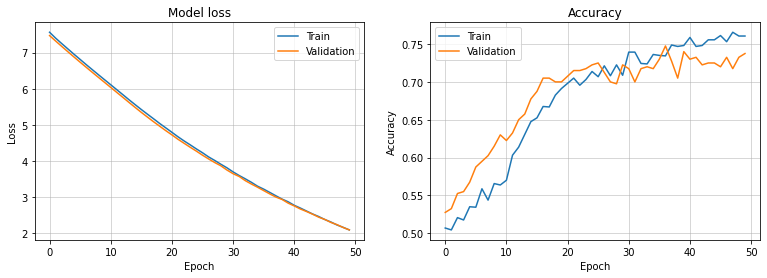

In [338]:
trainer.plot_train_history(history)

In [262]:
trainer.evaluate_model(X_test,y_test, source="gcp")

KeyboardInterrupt: 

In [243]:
predict_comp(X_test[0].reshape(1,100,772), source="gcp")

Model downloaded from Google Cloud Storage


array([[0.49404117]], dtype=float32)

In [248]:
result = rtp_input(move_df=move_df,
          source='gcp',
          white=True, api=False,
         data_path=path_eval)

Scaler downloaded from Google Cloud Storage
Data has been transformed into the correct format. ✅
            Training mode was disabled (Only X will be returned).
Model downloaded from Google Cloud Storage


In [251]:
result

0.4991569